<a href="https://colab.research.google.com/github/Mayaa722/Ai-safety-system/blob/main/Rainforest_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import files
import zipfile
import os

# Upload the dataset ZIP
uploaded = files.upload()

# Extract the dataset
zip_name = 'VIOLENCE VS NON_VIOLENCE.zip'
extract_path = 'dataset'

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check folders
print(os.listdir(extract_path))
print(os.listdir('dataset/VIOLENCE VS NON_VIOLENCE'))
print(os.listdir('dataset/VIOLENCE VS NON_VIOLENCE/train'))


Saving VIOLENCE VS NON_VIOLENCE.zip to VIOLENCE VS NON_VIOLENCE (1).zip
['VIOLENCE VS NON_VIOLENCE']
['train', 'test', 'val']
['violence', 'non_violence']


In [55]:
import glob
import os

DATA_DIR = 'dataset/VIOLENCE VS NON_VIOLENCE'
CLASSES = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print("Classes:", CLASSES)

def get_image_paths_labels(split):
    X_paths, y_labels = [], []
    for label, cls in enumerate(CLASSES):
        folder = os.path.join(DATA_DIR, split, cls)
        for img_path in glob.glob(os.path.join(folder, '*')):
            X_paths.append(img_path)
            y_labels.append(label)
    return X_paths, y_labels

X_train_paths, y_train = get_image_paths_labels('train')
X_val_paths, y_val = get_image_paths_labels('val')
X_test_paths, y_test = get_image_paths_labels('test')

print(f"Train: {len(X_train_paths)}, Val: {len(X_val_paths)}, Test: {len(X_test_paths)}")

Classes: ['non_violence', 'violence']
Train: 700, Val: 156, Test: 117


In [56]:
X_train_features = extract_features(X_train_paths)
X_val_features = extract_features(X_val_paths)
X_test_features = extract_features(X_test_paths)


In [57]:
import numpy as np
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# Load pretrained MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))

def extract_features(img_paths):
    features = []
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (224,224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feat = base_model.predict(x, verbose=0)
        features.append(feat.flatten())
    return np.array(features)

# Extract features for train, val, test
X_train_features = extract_features(X_train_paths)
X_val_features = extract_features(X_val_paths)
X_test_features = extract_features(X_test_paths)

print("Feature shapes:", X_train_features.shape, X_val_features.shape, X_test_features.shape)

Feature shapes: (700, 1280) (156, 1280) (117, 1280)


In [58]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_features, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [59]:
from sklearn.metrics import accuracy_score, classification_report

val_pred = rf.predict(X_val_features)
val_acc = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

print("Validation Classification Report:\n")
print(classification_report(y_val, val_pred, target_names=CLASSES))

Validation Accuracy: 0.8013
Validation Classification Report:

              precision    recall  f1-score   support

non_violence       0.75      0.90      0.82        78
    violence       0.87      0.71      0.78        78

    accuracy                           0.80       156
   macro avg       0.81      0.80      0.80       156
weighted avg       0.81      0.80      0.80       156



In [60]:
test_pred = rf.predict(X_test_features)
test_acc = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

print("Test Classification Report:\n")
print(classification_report(y_test, test_pred, target_names=CLASSES))

Test Accuracy: 0.7521
Test Classification Report:

              precision    recall  f1-score   support

non_violence       0.40      0.90      0.55        20
    violence       0.97      0.72      0.83        97

    accuracy                           0.75       117
   macro avg       0.69      0.81      0.69       117
weighted avg       0.87      0.75      0.78       117



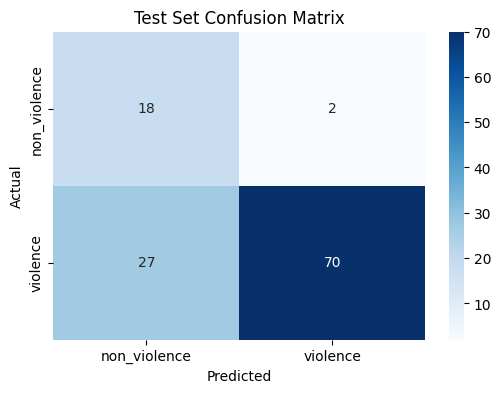

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix')
plt.show()

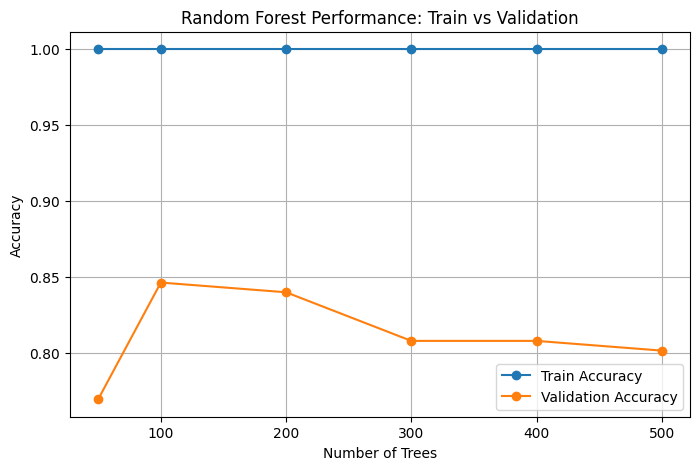

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Different numbers of trees to check performance
n_estimators_list = [50, 100, 200, 300, 400, 500]
train_scores, val_scores = [], []

for n in n_estimators_list:
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )
    rf_temp.fit(X_train_features, y_train)

    train_acc = accuracy_score(y_train, rf_temp.predict(X_train_features))
    val_acc = accuracy_score(y_val, rf_temp.predict(X_val_features))

    train_scores.append(train_acc)
    val_scores.append(val_acc)

# Plot the curve
plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, train_scores, marker='o', label='Train Accuracy')
plt.plot(n_estimators_list, val_scores, marker='o', label='Validation Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance: Train vs Validation')
plt.legend()
plt.grid(True)
plt.show()
